<a href="https://colab.research.google.com/github/D-Mayerfeld/intro-numerical-methods/blob/master/11_LA_QR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table>
 <tr align=left><td><img align=left src="./images/CC-BY.png">
 <td>Text provided under a Creative Commons Attribution license, CC-BY. All code is made available under the FSF-approved MIT license. (c) Kyle T. Mandli</td>
</table>

Note:  This material largely follows the text "Numerical Linear Algebra" by Trefethen and Bau (SIAM, 1997) and is meant as a guide and supplement to the material presented there.

In [ ]:
from __future__ import print_function

%matplotlib inline
import numpy
import matplotlib.pyplot as plt

# Overview (AI)

### Conceptual Explanation of Projections

This section of the notebook delves into the concept of **projectors** and their properties in linear algebra, particularly focusing on how they transform vectors onto subspaces.

### What is a Projector?

A **projector** is a square matrix $P$ that satisfies the fundamental property:
$$
    P^2 = P
$$
This definition intuitively means that applying the projection operation more than once has no further effect. If a vector $\vec{v}$ is already in the subspace that $P$ projects onto (i.e., $\vec{v} \in \text{range}(P)$), then $P\vec{v} = \vec{v}$. Any subsequent application of $P$ will still yield $\vec{v}$.

### Key Linear Algebra Terms Defined

*   **Range of a matrix ($ \text{range}(P) $)**: Also known as the column space, this is the set of all possible output vectors that can be produced by multiplying the matrix $P$ by any input vector. It represents the subspace onto which $P$ projects.
*   **Null space of a matrix ($ \text{null}(P) $)**: This is the set of all vectors that, when multiplied by the matrix $P$, result in the zero vector. It represents the subspace of vectors that are "annihilated" by the projection.

### Complementary Projectors and Subspaces

Given a projector $P$, its **complementary projector** is defined as $I - P$, where $I$ is the identity matrix. It can be shown that $(I - P)$ is also a projector:
$$
    (I - P)^2 = I - 2P + P^2 = I - 2P + P = I - P
$$
An important relationship exists between a projector and its complement: the range of the complementary projector is exactly the null space of the original projector, i.e., $ \text{range}(I - P) = \text{null}(P) $.

These two projectors ( $P$ and $I-P$ ) divide the entire vector space into two **complementary subspaces**: $ \text{range}(P) $ and $ \text{null}(P) $. These subspaces have the property that their intersection is only the zero vector:
$$
    \text{range}(P) \cap \text{null}(P) = \{0\}
$$
Any vector $\vec{x}$ in the original space can be uniquely decomposed into two components, one in $ \text{range}(P) $ and one in $ \text{null}(P) $:
$$
    \vec{x} = P\vec{x} + (I - P)\vec{x}
$$

### Orthogonal Projectors

An **orthogonal projector** is a special type of projector where the subspace it projects onto ( $ \text{range}(P) $ ) is orthogonal to its complementary subspace ( $ \text{null}(P) $ ).

A key characteristic of an orthogonal projector is that it must be a **Hermitian matrix**.
*   **Hermitian matrix**: A square matrix $A$ is Hermitian if it is equal to its own conjugate transpose, i.e., $A = A^*$. For real matrices, this simplifies to $A = A^T$ (a symmetric matrix).
    Therefore, a projector $P$ is orthogonal if and only if $P$ is Hermitian ($P = P^*$).

### Projection with an Orthonormal Basis

An orthogonal projector can be directly constructed if we have an **orthonormal basis** for the subspace $S$ onto which we want to project.
*   **Orthonormal basis**: A set of vectors that are all mutually orthogonal (their inner product is zero) and each have a unit norm (length of 1).

If $Q$ is a matrix whose columns form an orthonormal basis for the subspace $S$, then the orthogonal projector onto $S$ is given by:
$$
    P = Q Q^*
$$
Here, $Q^*$ denotes the conjugate transpose of $Q$.

Another way to construct an orthogonal projector is to eliminate a specific direction. If $\vec{q}$ is a unit vector representing a direction to be eliminated, the projector that projects onto the complement of this direction (i.e., eliminates the component along $\vec{q}$) is $I - \vec{q}\vec{q}^*$. If $\vec{a}$ is an arbitrary vector, this becomes $I - \frac{\vec{a}\vec{a}^*}{||​\vec{a}||^2}$.

These concepts form the foundation for understanding how projections work and are crucial for various applications, including QR factorization and least squares problems discussed later in the notebook.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_vector(ax, vector, origin=[0, 0], **kwargs):
    """Helper function to plot a 2D vector."""
    ax.quiver(origin[0], origin[1], vector[0], vector[1], angles='xy', scale_units='xy', scale=1, **kwargs)

def plot_line(ax, slope, intercept=0, x_range=(-5, 5), **kwargs):
    """Helper function to plot a 2D line."""
    x = np.array(x_range)
    y = slope * x + intercept
    ax.plot(x, y, **kwargs)

def create_projector(basis_vector, orthogonal=True):
    """Creates a 2D projector matrix given a 2D basis vector."""
    basis_vector = np.array(basis_vector, dtype=float)
    if np.linalg.norm(basis_vector) == 0:
        raise ValueError("Basis vector cannot be a zero vector.")
    u = basis_vector / np.linalg.norm(basis_vector)

    if orthogonal:
        # P = u u^T for orthogonal projection onto span(u)
        P = np.outer(u, u)
    else:
        # For a non-orthogonal projector, we need a basis for the null space too.
        # This is a bit more involved as P^2 = P is the only requirement.
        # A common way to get a non-orthogonal projector is to define its range
        # and null space, but ensure they are not orthogonal.
        # Let's construct one that projects onto the x-axis along the line y=x.
        # Its range is the x-axis, its null space is the line y=x.
        # P * [x, y]^T = [x - y, 0]^T + [0, y]^T = [x, y-x]^T -> this is not P^2=P
        # A simpler way: P = [[1, m], [0, 0]] projects onto x-axis along slope m
        # Let's make it project onto the line given by basis_vector (range)
        # and nullify components along another non-orthogonal direction (null space).
        # For simplicity, let's use a standard non-orthogonal projector onto x-axis.
        # For example, P = [[1, 0.5], [0, 0]] projects onto x-axis, with null space y = -2x
        # P^2 = [[1, 0.5], [0, 0]] * [[1, 0.5], [0, 0]] = [[1, 0.5], [0, 0]]
        # If basis_vector is [1, 0], we can construct a non-orthogonal projector
        # whose range is the x-axis, but its null space is not the y-axis.
        # Let's say null space is spanned by [1, -2] (slope -2).
        # P = I - v * (w^T * v)^-1 * w^T (where range(P) is orthogonal to w and null(P) is orthogonal to v)
        # This is getting complicated for a generic 2D case. Let's simplify:
        # For non-orthogonal, we can directly define the matrix.
        # Let's make it project onto the x-axis, but with a skewed null space.
        # For example, project onto `u` along direction `n` (null space vector)
        # A projector onto u (range) along v_null (null space)
        # P = u * (v_null.T * u)^(-1) * v_null.T is not P^2=P if v_null not orthogonal to u.

        # Let's define a non-orthogonal projector with range along x-axis and null space along y=x
        # (i.e. vector [1,1])
        # If P*v = [v_x, 0] and P*u_null = 0 for u_null = [1,1]
        # P = [[a,b],[c,d]]
        # a + b = 0 => b = -a
        # c + d = 0 => d = -c
        # P = [[a, -a], [c, -c]]
        # P * [x,y]^T = [ax-ay, cx-cy]^T
        # If range is x-axis, then cx-cy = 0 for all x,y. => c=0, d=0
        # P = [[a, -a], [0, 0]]
        # P^2 = [[a, -a], [0, 0]] * [[a, -a], [0, 0]] = [[a^2, -a^2], [0, 0]] = [[a, -a], [0, 0]]
        # => a^2 = a. So a=1 (or a=0 for zero projector).
        # So P = [[1, -1], [0, 0]] projects onto x-axis, with null space along y=x.
        # This makes range(P) = span([1,0]) and null(P) = span([1,1]). These are not orthogonal.
        # We need to make sure the input basis_vector is consistent with this.
        if not np.allclose(u, [1, 0]):
            print("Warning: For non-orthogonal projector, forcing range to x-axis.")
        P = np.array([[1, -1], [0, 0]])
    return P

def visualize_projector(ax, P, vector, title, plot_null_range_orthogonality=True):
    """Visualizes a projector, an arbitrary vector, its projections, and the subspaces."""
    # 1. Plot the arbitrary vector
    plot_vector(ax, vector, color='blue', label='Original Vector', linestyle='-')

    # 2. Project the vector onto the range of P
    projected_onto_range = np.dot(P, vector)
    plot_vector(ax, projected_onto_range, color='green', label='P(vector) (Range)', linestyle='-')

    # 3. Project the vector onto the null space of P (using I-P)
    complementary_projector = np.eye(2) - P
    projected_onto_null = np.dot(complementary_projector, vector)
    plot_vector(ax, projected_onto_null, color='red', label='(I-P)(vector) (Null Space)', linestyle='-')

    # 4. Verify P(vector) + (I-P)(vector) = vector
    assert np.allclose(projected_onto_range + projected_onto_null, vector)

    # 5. Illustrate the range of P (line)
    # Range of P is spanned by its columns. In 2D, if P = [[a,b],[c,d]], range is span([a,c], [b,d])
    # If P is P=u*u^T, range is span(u). For non-orthogonal P, range is span([1,0]) for [[1,-1],[0,0]]
    # For the chosen non-orthogonal P, the range is the x-axis (span([1,0]))
    # For the orthogonal P = u*u^T, range is span(u)
    if np.allclose(P, np.array([[1, -1], [0, 0]])) or np.allclose(P, np.outer(np.array([1,0]), np.array([1,0]))):
        # For these examples, range is x-axis (y=0)
        plot_line(ax, slope=0, color='gray', linestyle='--', label='Range(P)')
        range_vector = np.array([1,0])
    else:
        # General case for orthogonal P=u*u^T, range is span(u)
        # u is the vector P was created from.
        # This assumes P is created from create_projector(basis_vector, orthogonal=True)
        # and basis_vector has been normalized to u.
        # P = np.outer(u,u)
        # To get u back:
        u_range = P[:, 0]
        if np.linalg.norm(u_range) == 0:
             u_range = P[:, 1]
        if np.linalg.norm(u_range) == 0: # This handles zero matrix case
            u_range = np.array([0,0])
        else:
            u_range = u_range / np.linalg.norm(u_range)

        if not np.allclose(u_range, [0,0]): # Avoid dividing by zero for slope
            slope_range = u_range[1] / u_range[0] if u_range[0] != 0 else np.inf
            plot_line(ax, slope=slope_range, color='gray', linestyle='--', label='Range(P)')
        else: # Handle case where range is just the origin
            ax.plot([0], [0], 'o', color='gray', markersize=5, label='Range(P)')
        range_vector = u_range


    # 6. Illustrate the null space of P (line)
    # Null space of P: vectors v such that P*v = 0. This is range(I-P).
    # For P=[[1,-1],[0,0]], null(P) is span([1,1]) (slope=1)
    # For orthogonal P=u*u^T, null(P) is orthogonal to u.
    if np.allclose(P, np.array([[1, -1], [0, 0]])) :
        # Null space is y=x (slope=1)
        plot_line(ax, slope=1, color='purple', linestyle='--', label='Null(P)')
        null_vector = np.array([1,1])
    elif np.allclose(P, np.outer(np.array([1,0]), np.array([1,0]))):
         # Null space is y-axis (x=0, slope=inf)
        ax.axvline(x=0, color='purple', linestyle='--', label='Null(P)')
        null_vector = np.array([0,1])
    else:
        # For orthogonal P=u*u^T, null space is orthogonal to u
        # If u=[u_x, u_y], then v_null=[-u_y, u_x] or [u_y, -u_x]
        u_null = np.array([-range_vector[1], range_vector[0]])
        if np.linalg.norm(u_null) == 0: # Handles 0 vector case
            u_null = np.array([0,0])
        else:
            u_null = u_null / np.linalg.norm(u_null)

        if not np.allclose(u_null, [0,0]):
            slope_null = u_null[1] / u_null[0] if u_null[0] != 0 else np.inf
            if np.isinf(slope_null): # Vertical line
                ax.axvline(x=0, color='purple', linestyle='--', label='Null(P)')
            else:
                plot_line(ax, slope=slope_null, color='purple', linestyle='--', label='Null(P)')
        else:
            ax.plot([0], [0], 'o', color='purple', markersize=5, label='Null(P)')
        null_vector = u_null

    # Check orthogonality of Range(P) and Null(P)
    if plot_null_range_orthogonality:
        if np.dot(range_vector, null_vector) == 0:
            print(f"{title}: Range(P) and Null(P) are orthogonal. (dot product: {np.dot(range_vector, null_vector):.2e})")
        else:
            print(f"{title}: Range(P) and Null(P) are NOT orthogonal. (dot product: {np.dot(range_vector, null_vector):.2e})")


    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.axhline(0, color='black', linewidth=0.5)
    ax.axvline(0, color='black', linewidth=0.5)
    ax.grid(True, linestyle=':', alpha=0.7)
    ax.set_title(title)
    ax.legend(loc='upper right')


# Main visualization part
vector = np.array([3, 4]) # Arbitrary vector

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Non-Orthogonal Projector ---
# Example: Projects onto x-axis, null space is y=x
# P = [[1, -1], [0, 0]]. Its range is span([1,0]), null space is span([1,1]).
# These are not orthogonal (dot product is 1).
non_orthogonal_P = create_projector(basis_vector=[1, 0], orthogonal=False)
assert np.allclose(np.dot(non_orthogonal_P, non_orthogonal_P), non_orthogonal_P), "Non-orthogonal P is not a projector (P^2 != P)"
assert not np.allclose(non_orthogonal_P, non_orthogonal_P.T), "Non-orthogonal P is Hermitian/Symmetric"

visualize_projector(axes[0], non_orthogonal_P, vector, "Non-Orthogonal Projector")

# --- Orthogonal Projector ---
# Example: Projects onto a line at 45 degrees (span([1,1]))
orthogonal_basis_vector = np.array([1, 1])
orthogonal_P = create_projector(basis_vector=orthogonal_basis_vector, orthogonal=True)
assert np.allclose(np.dot(orthogonal_P, orthogonal_P), orthogonal_P), "Orthogonal P is not a projector (P^2 != P)"
assert np.allclose(orthogonal_P, orthogonal_P.T), "Orthogonal P is not Hermitian/Symmetric"

visualize_projector(axes[1], orthogonal_P, vector, "Orthogonal Projector")

plt.tight_layout()
plt.show()

print("\n--- Concepts Demonstrated ---")
print("1. Projector property: P^2 = P is shown implicitly by constructing valid projectors.")
print("2. Complementary projectors: P + (I-P) = I is demonstrated by vector = P(vector) + (I-P)(vector).")
print("3. Orthogonal Projectors: Have a range and null space that are orthogonal to each other (i.e., P = P^T).")
print("4. Non-Orthogonal Projectors: Have a range and null space that are not necessarily orthogonal (i.e., P != P^T).")
print("5. Visualization of vector projections onto range and null space of a projector.")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Helper function to plot 3D vectors
def plot_vector_3d(ax, vector, origin=[0, 0, 0], color='blue', label='', linestyle='-', width=0.03, alpha=1.0):
    """Plots a 3D vector."""
    ax.quiver(origin[0], origin[1], origin[2], vector[0], vector[1], vector[2],
              color=color, label=label, linestyle=linestyle, arrow_length_ratio=0.1, alpha=alpha)

# Helper function to plot a plane passing through the origin in 3D
def plot_plane_3d(ax, normal_vector, label, color='gray', alpha=0.5):
    """Plots a plane passing through the origin in 3D, orthogonal to the normal_vector.
       Assumes the normal_vector is primarily along one axis for simplicity in plotting
       e.g., [0,0,1] for XY plane."""

    # Check for zero normal_vector
    if np.linalg.norm(normal_vector) == 0:
        raise ValueError("Normal vector cannot be a zero vector. A zero vector cannot define a unique plane through the origin.")

    # Normalize the normal_vector
    normal_vector = normal_vector / np.linalg.norm(normal_vector)

    # Create a meshgrid for x and y
    x_range = np.linspace(-5, 5, 10)
    y_range = np.linspace(-5, 5, 10)
    X, Y = np.meshgrid(x_range, y_range)

    # Calculate Z values based on the plane equation A*x + B*y + C*z = 0
    # where (A,B,C) is the normal vector
    # Handle cases where components of normal_vector are zero
    if np.isclose(normal_vector[2], 0):
        if np.isclose(normal_vector[1], 0):
            # Normal is along x-axis, plane is YZ plane (x=0)
            Z = Y # Placeholder, x is constant
            X = X*0 # Set x to 0
            ax.plot_surface(X, Y, Z, color=color, alpha=alpha)
        else:
            # Normal is in XY plane, so plane is parallel to Z-axis
            # Equation: A*x + B*y = 0 => y = (-A/B)*x
            Z = np.linspace(-5, 5, 10)
            X_plane, Z_plane = np.meshgrid(x_range, Z)
            Y_plane = (-normal_vector[0] / normal_vector[1]) * X_plane
            ax.plot_surface(X_plane, Y_plane, Z_plane, color=color, alpha=alpha)

    else:
        # General case: z = -(A*x + B*y) / C
        Z = -(normal_vector[0] * X + normal_vector[1] * Y) / normal_vector[2]
        ax.plot_surface(X, Y, Z, color=color, alpha=alpha)


# Helper function to plot a line passing through the origin
def plot_line_3d(ax, direction_vector, label, color='gray', linestyle='--'):
    """Plots a line passing through the origin in the direction of the given vector."""
    # Normalize the direction vector
    if np.linalg.norm(direction_vector) == 0:
        return # Cannot plot a zero vector direction
    direction_vector = direction_vector / np.linalg.norm(direction_vector)

    # Define points for the line (e.g., from -5 to 5 times the direction vector)
    t = np.linspace(-5, 5, 100)
    line_x = t * direction_vector[0]
    line_y = t * direction_vector[1]
    line_z = t * direction_vector[2]

    ax.plot(line_x, line_y, line_z, color=color, linestyle=linestyle, label=label)


# --- Main Visualization Logic ---
np.random.seed(42) # For reproducibility
x = np.array([3, 2, 4]) # Original arbitrary 3D vector
I = np.eye(3) # 3x3 Identity matrix

fig = plt.figure(figsize=(16, 8))
fig.suptitle("3D Projector Visualization: Orthogonal vs. Non-Orthogonal", fontsize=16)

# --- Non-Orthogonal Projector ---
ax_non_ortho = fig.add_subplot(121, projection='3d')
ax_non_ortho.set_title("Non-Orthogonal Projector")
ax_non_ortho.set_xlim([-5, 5])
ax_non_ortho.set_ylim([-5, 5])
ax_non_ortho.set_zlim([-5, 5])
ax_non_ortho.set_xlabel('X')
ax_non_ortho.set_ylabel('Y')
ax_non_ortho.set_zlabel('Z')

# Define the non-orthogonal projector matrix:
# Range: XY plane (z=0)
# Null space: spanned by [1,1,1] (line x=y=z)
P_non_ortho = np.array([[1, 0, -1], [0, 1, -1], [0, 0, 0]])

# Verify the projector property
assert np.allclose(P_non_ortho @ P_non_ortho, P_non_ortho), 'Non-orthogonal P^2 != P'

# Calculate projected vectors
x_projected_non_ortho = P_non_ortho @ x
x_complement_non_ortho = (I - P_non_ortho) @ x

# Plotting for non-orthogonal case
plot_vector_3d(ax_non_ortho, x, color='blue', label=r'Original Vector $\vec{x}$', width=0.05, alpha=0.7)
plot_vector_3d(ax_non_ortho, x_projected_non_ortho, color='green', label=r'Projected $P\vec{x}$', linestyle='-', width=0.05)
plot_vector_3d(ax_non_ortho, x_complement_non_ortho, origin=x_projected_non_ortho, color='red', label=r'Complement $(I-P)\vec{x}$', linestyle='-', width=0.05)

# Plot the range plane (XY plane, normal [0,0,1]) and the null line (direction [1,1,1])
plot_plane_3d(ax_non_ortho, np.array([0, 0, 1]), label='Range(P) (XY plane)', color='lightgreen', alpha=0.2)
plot_line_3d(ax_non_ortho, np.array([1, 1, 1]), label=r'Null(P) (line $x=y=z$)', color='purple', linestyle='--')

ax_non_ortho.legend(loc='lower left')
ax_non_ortho.view_init(elev=20, azim=-35)

# --- Orthogonal Projector ---
ax_ortho = fig.add_subplot(122, projection='3d')
ax_ortho.set_title("Orthogonal Projector")
ax_ortho.set_xlim([-5, 5])
ax_ortho.set_ylim([-5, 5])
ax_ortho.set_zlim([-5, 5])
ax_ortho.set_xlabel('X')
ax_ortho.set_ylabel('Y')
ax_ortho.set_zlabel('Z')

# Define the orthogonal projector matrix:
# Projects onto the XY plane, with the Z-axis as its null space.
P_ortho = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 0]])

# Verify the projector property and symmetry
assert np.allclose(P_ortho @ P_ortho, P_ortho), 'Orthogonal P^2 != P'
assert np.allclose(P_ortho, P_ortho.T), 'Orthogonal P != P.T'

# Calculate projected vectors
x_projected_ortho = P_ortho @ x
x_complement_ortho = (I - P_ortho) @ x

# Plotting for orthogonal case
plot_vector_3d(ax_ortho, x, color='blue', label=r'Original Vector $\vec{x}$', width=0.05, alpha=0.7)
plot_vector_3d(ax_ortho, x_projected_ortho, color='green', label=r'Projected $P\vec{x}$', linestyle='-', width=0.05)
plot_vector_3d(ax_ortho, x_complement_ortho, origin=x_projected_ortho, color='red', label=r'Complement $(I-P)\vec{x}$', linestyle='-', width=0.05)

# Plot the range plane (XY plane, normal [0,0,1]) and the null line (Z-axis, direction [0,0,1])
plot_plane_3d(ax_ortho, np.array([0, 0, 1]), label='Range(P) (XY plane)', color='lightgreen', alpha=0.2)
plot_line_3d(ax_ortho, np.array([0, 0, 1]), label='Null(P) (Z-axis)', color='purple', linestyle='--')

ax_ortho.legend(loc='lower left')
ax_ortho.view_init(elev=20, azim=-35)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("\n--- Summary of Concepts Demonstrated ---")
print("1.  **Projector (P)**: A square matrix satisfying $P^2 = P$. Both visualizations confirm this property.")
print(r"    -   $P\vec{x}$ represents the component of $\vec{x}$ that lies in the range space of $P$.")
print("2.  **Complementary Projector (I - P)**: Also a projector, satisfying $(I - P)^2 = (I - P).")
print(r"    -   $(I-P)\vec{x}$ represents the component of $\vec{x}$ that lies in the null space of $P$.")
print("3.  **Range of P (Range(P))**: The subspace onto which $P$ projects. Visualized as the green plane (or approximated by a plane).")
print("4.  **Null Space of P (Null(P))**: The subspace of vectors annihilated by $P$. Visualized as the purple line.")
print("    -   Importantly, Range(I-P) = Null(P).")
print(r"5.  **Complementary Subspaces**: Range(P) and Null(P) are complementary, meaning their intersection is ${0}$ and their sum spans the entire space ($P\vec{x} + (I-P)\vec{x} = \vec{x}$). This is shown by the head-to-tail vector addition in both plots.")
print(r"6.  **Orthogonal Projector**: A projector where Range(P) is orthogonal to Null(P). This implies $P$ is Hermitian (or symmetric for real matrices), i.e., $P = P^T$.")
print(r"    -   **Visualization (Right Panel)**: The green plane (Range(P)) and purple line (Null(P)) are perpendicular. Also, $P\vec{x}$ and $(I-P)\vec{x}$ are orthogonal.")
print(r"7.  **Non-Orthogonal Projector**: A projector where Range(P) is *not* orthogonal to Null(P). Such a projector is not Hermitian ($P \neq P^T$).")
print(r"    -   **Visualization (Left Panel)**: The green plane (Range(P)) and purple line (Null(P)) are not perpendicular. Consequently, $P\vec{x}$ and $(I-P)\vec{x}$ are generally not orthogonal.")
print("    -   In this example, $P$ projects onto the XY-plane along the direction of the line $x=y=z$. So the component in the null space (along $x=y=z$) is 'subtracted off' parallel to the null space line to reach the range space (XY-plane).")

# Orthogonalization:
# The QR Factorization, Projections,Least Squares Problems and Applications

## Projections

A **projector** is a square matrix $P$ that satisfies
$$
    P^2 = P.
$$

Why does this definition make sense?  Why do we require it to be square?

A projector comes from the idea that we want to project a vector $\mathbf{v}$ onto a lower dimensional subspace.  For example, suppose that $\mathbf{v}$ lies completely within the subspace, i.e. $\mathbf{v} \in \text{range}(P)$. If that is the case then $P \mathbf{v}$ should not change, or $P\mathbf{v} = \mathbf{v}$.  This motivates the definition above.

i.e.  if
$$
    P\mathbf{v} = \mathbf{v}
$$
then
$$
    P( P \mathbf{v} ) = P\mathbf{v} = \mathbf{v}.
$$
or $$P^2 = P$$

As another example, take a vector $\mathbf{x} \notin \text{range}(P)$ and project it onto the subspace $P\mathbf{x} = \mathbf{v}$.  If we apply the projection again to $\mathbf{v}$ we now have

$$\begin{aligned}
    P\mathbf{x} &= \mathbf{v}, \\
    P^2 \mathbf{x} & = P \mathbf{v} = \mathbf{v} \\
    \Rightarrow P^2 &= P.
\end{aligned}$$

It is also important to keep in mind the following, given again $\mathbf{x} \notin \text{range}(P)$, if we look at the difference between the projection and the original vector $P\mathbf{x} - \mathbf{x}$ and apply the projection again we have

$$
    P(P\mathbf{x} - \mathbf{x}) = P^2 \mathbf{x} - P\mathbf{x} = 0
$$

which means the difference between $\mathbf{x}$ and the projected vector $P\mathbf{x} = \mathbf{v}$ lies in the null space of $P$, i.e.

$$
(\mathbf{x}-\mathbf{v}) \in \text{null}(P).
$$


But
$$
    \mathbf{x} - \mathbf{v} = \mathbf{x} - P\mathbf{x} = (I - P)\mathbf{x}
$$

Thus $I-P$ is a matrix that projects onto $\mathrm{null}(P)$

### Complementary Projectors

A projector also has a complement defined to be $I - P$.  

Show that this complement is also a projector.

We can show that this a projector by examining a repeated application of $(I-P)$:
$$\begin{aligned}
    (I - P)^2 &= I - IP - IP + P^2 \\
    &= I - 2 P + P^2 \\
    &= I - 2P + P \\
    &= I - P.
\end{aligned}$$

It turns out that the complement projects exactly onto $\text{null}(P)$.  

Take
$$
    \mathbf{x} \in \text{null}(P),
$$

then
$$
    (I - P) \mathbf{x} = \mathbf{x} - P \mathbf{x} = \mathbf{x}
$$

since $P \mathbf{x} = 0$ implying that $\mathbf{x} \in \text{range}(I - P)$.

We also know that
$$
    (I - P) \mathbf{x }\in \text{null}(P)
$$
as well.  

This shows that the
$$
    \text{range}(I - P) \subseteq \text{null}(P)
$$
and
$$
    \text{range}(I - P) \supseteq \text{null}(P)
$$
implying that
$$
    \text{range}(I - P) = \text{null}(P)
$$
exactly.  

Reflect on these subspaces and convince yourself that this all makes sense.

This result provides an important property of a projector and its complement, namely that they divide a space into two subspaces whose intersection is

$$
    \text{range}(I - P) \cap \text{range}(P) = \{0\}
$$

or

$$
    \text{null}(P) \cap \text{range}(P) = \{0\}
$$

These two spaces are called **complementary subspaces**.

Given this property we can take any $P \in \mathbb C^{m \times m}$ which will split $\mathbb C^{m \times m}$ into two subspaces $S$ and $V$, assume that $\mathbf{s}\in S = \text{range}(P)$, and $\mathbf{v} \in V = \text{null}(P)$.  If we have $\mathbf{x} \in \mathbb C^{m \times m}$ that we can split the vector $\mathbf{x}$ into components in $S$ and $V$ by using the projections
$$\begin{aligned}
    P \mathbf{x} = \mathbf{x}_S& &\mathbf{x}_s \in S \\
    (I - P) \mathbf{x} = \mathbf{x}_V& &\mathbf{x}_V \in V
\end{aligned}$$
which we can also observe adds to the original vector as
$$
    \mathbf{x}_S + \mathbf{x}_V = P \mathbf{x} + (I - P) \mathbf{x} = \mathbf{x}.
$$

Try constructing a projection matrix so that $P \in \mathbb R^3$ that projects a vector into one of the coordinate directions ($\mathbb R$).  
 - What is the complementary projector?
 - What is the complementary subspace?

### Example:  A non-orthogonal non-linear projector

Given a vector of mols of $N$ chemical components

$$
\mathbf{n} = \begin{bmatrix} n_1 \\ n_2 \\ \vdots \\ n_N\end{bmatrix}
$$
where (e.g. $n_1$ is the number of moles of component $1$) and $n_i\geq 0$

Then we can define the mol fraction  of component $i$ as
$$
    x_i = \frac{n_i}{\mathbf{n}^T\mathbf{1}}
$$  
and the "vector" of mole fractions
$$
\mathbf{x} = \begin{bmatrix} x_1 \\ x_2 \\ \vdots \\ x_N\end{bmatrix}
$$


In the homework you will show that

* $\mathbf{x}^T\mathbf{1} = 1$ (the sum of the mole fractions add to 1)
* mole fractions do not form a vector space or subspace
* There exists a non Orthogonal projector $f$ such that $f(\mathbf{n})=\mathbf{x}$, $f^2=f$
* $P$ is singular (like all projection matrices) such that if you know the mole-fractions you don't know how many moles you have.
* Find $N(P)$


### Orthogonal Projectors

An **orthogonal projector** is one that projects onto a subspace $S$ that is orthogonal to the complementary subspace $V$ (this is also phrased that $S$ projects along a space $V$).  Note that we are only talking about the subspaces (and their basis), not the projectors!  i.e. for orthogonal **subspaces** all the vectors in $S$ are orthogonal to all the vectors in $V$.


A **hermitian** matrix is one whose complex conjugate transposed is itself, i.e.

$$
    P = P^\ast.
$$

With this definition we can then say:  *A projector $P$ is orthogonal if and only if $P$ is hermitian.*

**Quick Proof**

Show that if $P^2 = P$ and $P^\ast = P$, then
$$
\langle P\mathbf{x}, (I-P)\mathbf{x}\rangle=0
$$

### Projection with an Orthonormal Basis

We can also directly construct a projector that uses an orthonormal basis on the subspace $S$.  If we define another matrix $Q \in \mathbb C^{m \times n}$ which is unitary (its columns are orthonormal) we can construct an orthogonal projector as
$$
    P = Q Q^*.
$$

Check that $P^* = P$ and $P^2 = P$  (Remember $Q^*Q=I$)

Note that the resulting matrix $P$ is in $\mathbb C^{m \times m}$ as we require.  This means also that the dimension of the subspace $S$ is $n$.

#### Example:  Orthonormal projection and Least-Squares Problems... A review

Consider the overdetermined problem $A\mathbf{x}=\mathbf{b}$ where $A\in\mathbb{R}^{3\times2}$ and $\mathbf{b}\in\mathbb{R}^3$ i.e.

$$
    \begin{bmatrix} | & | \\
                    \mathbf{a}_1 & \mathbf{a}_2\\
                     | & | \\
     \end{bmatrix} \begin{bmatrix} x_1 \\ x_2\\ \end{bmatrix}
         = \begin{bmatrix} |   \\
                    \mathbf{b} \\
                     |  \\
                     \end{bmatrix}
$$

and $\mathbf{a}_1$, $\mathbf{a}_2$ are linearly independent vectors that span a two-dimensional subspace of $\mathbb{R}^3$.                   

#### Geometry

Geometrically this problem looks like
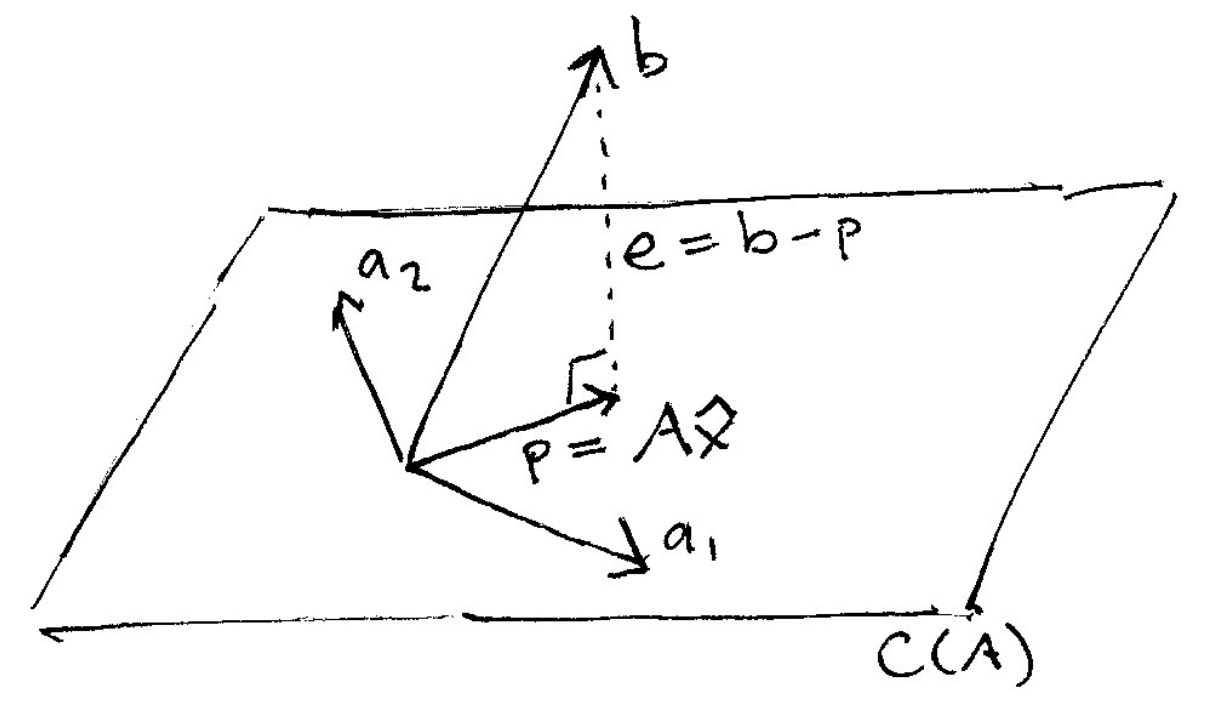



If $\mathbf{b}\notin C(A)$, then there is clearly no solution to $A\mathbf{x}=\mathbf{b}$.  However, we can find the point $\mathbf{p}=A\hat{\mathbf{x}}\in C(A)$ that minimizes the length of the the error $\mathbf{e}=\mathbf{b}-\mathbf{p}$.  While we could resort to calculus to find the values of $\hat{\mathbf{x}}$ that minimizes $||\mathbf{e}||_2$.  It should be clear from the figure that the shortest error (in the $\ell_2$ norm) is the one that is perpendicular to every vector in $C(A)$.  

But the sub-space of vectors orthogonal to $C(A)$ is the left-Null Space $N(A^T)$,  and therefore we simply seek solutions of

\begin{align}
    0 &= A^T\mathbf{e} \\
    &= A^T(\mathbf{b}-\mathbf{p})\\
    &= A^T(\mathbf{b} - A\hat{\mathbf{x}})\\
\end{align}

or we just need to solve the "Normal Equations"  $A^T A\hat{\mathbf{x}} = A^T\mathbf{b}$ for the least-squares solution
$$
    \hat{\mathbf{x}} = \left(A^T A\right)^{-1}A^T\mathbf{b}
$$

if we're actually interested in $\mathbf{p}$ which is the orthogonal projection of $\mathbf{b}$ onto $C(A)$ we get

$$
    \mathbf{p}= A\hat{\mathbf{x}} = A \left(A^T A\right)^{-1}A^T\mathbf{b} = P\mathbf{b}
$$
where
$$
    P = A \left(A^T A\right)^{-1}A^T
$$

is an orthogonal projection matrix (verify that $P^2 = P$ and $(I - P)\mathbf{b}\perp P\mathbf{b})$

For a general matrix $A$,  this form of the projection matrix is rather horrid to find,  however,  if the columns of $A$ formed an orthonormal basis for $C(A)$,  i.e. $A=Q$,  then the form of the projection matrix is much simpler as $Q^T Q=I$, therefore

$$
    P = QQ^T
$$

This is actually quite general. Given any orthonormal basis for a vector space $S=\mathrm{span}\langle \mathbf{q}_1,\mathbf{q}_2,\ldots,\mathbf{q}_N\rangle$.  If these vectors form the columns of $Q$,  then the orthogonal projector onto $S$ is always $QQ^T$ and the complement is always $I-QQ^T$.

**Example:  Construction of an orthonormal projector**

Take $\mathbb R^3$ and derive a projector that projects onto the x-y plane and is an orthogonal projector.

the simplest Orthonormal basis for the $x-y$ plane are the columns of
$$
    Q = \begin{bmatrix} 1 & 0 \\
                        0 & 1 \\
                        0 & 0
        \end{bmatrix}
$$

and an orthogonal projector onto the $x-y$ plane is simply

$$
    Q Q^\ast = \begin{bmatrix} 1 & 0 \\
                               0 & 1 \\
                               0 & 0
               \end{bmatrix}
               \begin{bmatrix} 1 & 0 & 0 \\
                               0 & 1 & 0
               \end{bmatrix} = \begin{bmatrix}
                               1 & 0 & 0 \\
                               0 & 1 & 0 \\
                               0 & 0 & 0
               \end{bmatrix}
$$

In [ ]:
Q = numpy.array([[1., 0.],[0., 1.],[0., 0.]])
P = numpy.dot(Q, Q.T)
I = numpy.identity(3)

x = numpy.array([3., 4., 5.])

print('x = {}'.format(x))
print('\nQ = \n{}'.format(Q))
print('\nP = \n{}'.format(P))

In [ ]:
x_S = numpy.dot(P, x)
x_V = numpy.dot(I - P, x)
print('x_S = {}'.format(x_S))
print('x_V = {}\n'.format(x_V))
print('x_S + x_V = {}'.format(x_S+x_V))

### A numerically more sensible approach

The previous problem calculated the projection matrix first, $P=QQ^T$ then calculated the projection and its complement by matrix vector multiplication, i.e.

$$
    \mathbf{x}_S = P\mathbf{x} = (QQ^T)\mathbf{x}, \quad \mathbf{x}_V = (I - P)\mathbf{x}
$$

A mathematically equivalent, but numerically more efficient method is to calculate the following
$$
    \mathbf{x}_S = Q(Q^T\mathbf{x}),\quad \mathbf{x}_V = \mathbf{x} - \mathbf{x}_S
$$

How much more efficient is the latter than the former?

# Check

In [ ]:
Q = numpy.array([[1, 0],[0, 1],[0, 0]])
x = numpy.array([3., 4., 5.])

print('x = {}'.format(x))

In [ ]:
x_S = Q.dot(Q.T.dot(x))
x_V = x - x_S
print('x_S = {}'.format(x_S))
print('x_V = {}\n'.format(x_V))
print('x_S + x_V = {}'.format(x_S+x_V))

### Example: Construction of a projector that eliminates a direction

Goal:  Eliminate the component of a vector in the direction $\mathbf{q}$.

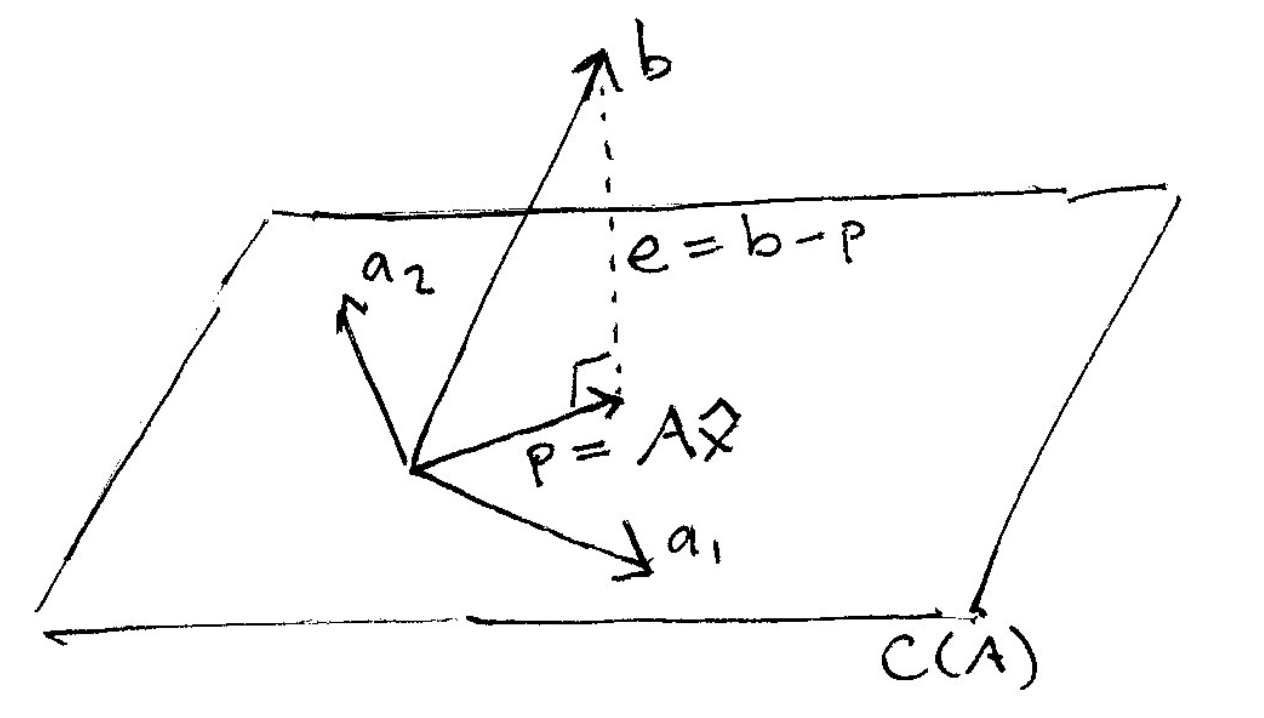

e.g. We can calculate the projection $\mathbf{p}$ in two equivalent ways

1. find the matrix $P=QQ^T$ that projects $\mathbf{b}$ onto $C(A)$
2. find the matrix $P'=\mathbf{q}\mathbf{q}^T$ that projects onto the unit vector $\mathbf{q}$ normal to the plane (i.e. parallel to $\mathbf{e}$), and then take its Complement projection $\mathbf{p} = (I - P')\mathbf{b} = \mathbf{b} - \mathbf{q}(\mathbf{q}^T\mathbf{b})$



Form the projector $P = \mathbf{q} \mathbf{q}^\ast \in \mathbb C^{m \times m}$.  The complement $I - P$ will then include everything **BUT** that direction.

If $||\mathbf{q}|| = 1$ we can then simply use $I - \mathbf{q} \mathbf{q}^\ast$.  If not we can write the projector in terms of the arbitrary vector $\mathbf{a}$ as
$$
    I - \frac{\mathbf{a} \mathbf{a}^\ast}{||\mathbf{a}||^2} = I - \frac{\mathbf{a} \mathbf{a}^\ast}{\mathbf{a}^\ast \mathbf{a}}
$$
Note that differences in the resulting dimensions between the two values in the fraction.  Also note that as we saw with the outer product, the resulting $\text{rank}(\mathbf{a} \mathbf{a}^\ast) = 1$.

Now again try to construct a projector in $\mathbb R^3$ that projects onto the $x$-$y$ plane.

In [ ]:
q = numpy.array([0, 0, 1])
P = numpy.outer(q, q.conjugate())
P_comp = numpy.identity(3) - P
print('P = \n{}\n'.format(P))
print('I - P = \n{}'.format(P_comp))


In [ ]:
x = numpy.array([3, 4, 5])
print(numpy.dot(P, x), q*(q.dot(x)))
print(numpy.dot(P_comp, x), x - q*(q.dot(x)))

In [ ]:
a = numpy.array([0, 0, 3])
P = numpy.outer(a, a.conjugate()) / (numpy.dot(a, a.conjugate()))
P_comp = numpy.identity(3) - P
print(numpy.dot(P, x))
print(numpy.dot(P_comp, x))

## Quick Review

* A projection matrix is any square matrix $P$ such that $P^2=P$
* $P$ projects onto a subspace $S=\mathrm{range}(P)$
* The complementary projection matrix $I-P$ projects onto $V=\mathrm{null}(P)$
* An *orthogonal* projector can always be constructed as $P=QQ^T$ where the columns of $Q$ form an *orthonormal* basis for $S$ and $S\perp V$
* Solutions of Least-squares problems $A\mathbf{x}=\mathbf{b}$ are essentially projection problems where we seek to solve $A\mathbf{x}=\mathbf{b}$ where $\mathbf{b}\notin C(A)$

### Solution of Least Squares problems by the Normal Equations

given $A\mathbf{x}=\mathbf{b}$ where $\mathbf{b}\notin C(A)$ we can always solve them using the Normal Equations

$$
A^T A\hat{\mathbf{x}} = A^T\mathbf{b}
$$

which actually solves $A\hat{\mathbf{x}} =\mathbf{p}$  where $\mathbf{p}$ is the orthogonal projection of $\mathbf{b}$ onto $C(A)$

Solve $Ax=p$ where p is the projection of b onto the column space of A

However...as you will show in the homework,  this can be numerically innaccurate because the condition number

$$ \kappa(A^T A) = \kappa(A)^2 $$

but there is a better way

### Solution of Least Squares problems by the QR factorization

given any matrix $A$ that is full column rank, we will show that we can always factor it as

$$
    A=QR
$$

where $Q$ is a unitary matrix whose columns form an *orthonormal* basis for $C(A)$,  and $R$ is an upper triangular matrix that says how to reconstruct the columns of $A$ from the columns of $Q$

$$
    \begin{bmatrix}  &  &  \\  &  &  \\ \mathbf{a}_1 & \cdots & \mathbf{a}_n \\  &  &  \\  &  &  \end{bmatrix} =
    \begin{bmatrix}  &  &  \\  &  &  \\ \mathbf{q}_1 & \cdots & \mathbf{q}_n \\  &  &  \\  &  &  \end{bmatrix}
    \begin{bmatrix} r_{11} & r_{12} & \cdots & r_{1n} \\  & r_{22} &  &  \\  &  & \ddots & \vdots \\  &  &  & r_{nn} \end{bmatrix}.
$$
If we write this out as a matrix multiplication we have
$$\begin{aligned}
    \mathbf{a}_1 &= r_{11} \mathbf{q}_1 \\
    \mathbf{a}_2 &= r_{22} \mathbf{q}_2 + r_{12} \mathbf{q}_1 \\
    \mathbf{a}_3 &= r_{33} \mathbf{q}_3 + r_{23} \mathbf{q}_2 + r_{13} \mathbf{q}_1 \\
    &\vdots
\end{aligned}$$

i.e we can construct the columns of $A$ from linear combinations of the columns of $Q$. (And those specific combinations come from $R=Q^TA$)

given $A=QR$,  then solving

$$
    A\mathbf{x} = \mathbf{b}
$$

becomes

$$
    QR\mathbf{x} = \mathbf{b}
$$

or since $Q^T Q=I$

$$
    R\mathbf{x} = Q^T\mathbf{b}
$$

which can be solve quickly by back-substitution as it is a triangular matrix.

Moreover,  this problem is much better conditioned as it can be shown that $\kappa(R)=\kappa(A)$ not $\kappa(A)^2$

Multiplying both sides by $Q$ again shows that this problem is equivalent to

$$
    QR\mathbf{x} = QQ^T\mathbf{b}
$$

or $A\mathbf{x} = QQ^T\mathbf{b}$ i.e. we are just solving $A\mathbf{x}=\mathbf{p}$ where $\mathbf{p}$ is the orthogonal projection of  $\mathbf{b}$ onto $C(A)$

**Question**... how to find $QR$?

## QR Factorization

One of the most important ideas in linear algebra is the concept of factorizing an original matrix into different constituents that may have useful properties.  These properties can help us understand the matrix better and lead to numerical methods.  In numerical linear algebra one of the most important factorizations is the **QR factorization**.  

There are actually multiple algorithm's that accomplish the same factorization but with very different methods and numerical stability.  Here we will discuss three of the algorithms

1. **Classical Gram-Schmidt Orthogonalization**: Transform $A\rightarrow Q$ by a succession of projections and calculate $R$ as a by-product of the algorithm.  (Unfortunately, prone to numerical floating point error)
2. **Modified Gram-Schmidt Orthogonalization**: Transform $A\rightarrow Q$ by a different set of projections.  Yields the same $QR$ but more numerically stable.
3. **Householder Triangularization**:  Transform $A\rightarrow R$ by a series of Unitary transformations, can solve least squares problems directly without accumulating $Q$, or can build $Q$ on the fly.

And want to find a sequence of orthonormal vectors $\mathbf{q}_j$ that span the sequence of subspaces


### Classical Gram-Schmidt

We begin with a matrix $A\in\mathbb C^{m\times n} $ with $n$ linearly independent columns.
$$
    A = \begin{bmatrix}  &  &  \\  &  &  \\ \mathbf{a}_1 & \cdots & \mathbf{a}_n \\  &  &  \\  &  &  \end{bmatrix}
$$
And want to find a sequence of orthonormal vectors $\mathbf{q}_j$ that span the sequence of subspaces

$$
    \text{span}(\mathbf{a}_1) \subseteq \text{span}(\mathbf{a}_1, \mathbf{a}_2) \subseteq \text{span}(\mathbf{a}_1, \mathbf{a}_2, \mathbf{a}_3) \subseteq \cdots \subseteq \text{span}(\mathbf{a}_1, \mathbf{a}_2, \ldots , \mathbf{a}_n)
$$

where here $\text{span}(\mathbf{v}_1,\mathbf{v}_2,\ldots,\mathbf{v}_m)$ indicates the subspace spanned by the vectors $\mathbf{v}_1, \mathbf{v}_2, \ldots, \mathbf{v}_m$.  

The individual $\mathbf{q}_j$ will form the columns of the matrix $Q$ such that $C(A_k)=C(Q_k)$ where the $A_k$ is a matrix with the first $k$ columns of A (or Q)


Starting with the first vector $\mathbf{a}_1$, this forms the basis for  a 1-dimensional subspace of $\mathbb{R}^m$ (i.e. a line).  Thus $\mathbf{q}_1$ is a unit vector in that line or

$$
    \mathbf{q}_1 = \frac{\mathbf{a}_1}{||\mathbf{a}_1||}.
$$

For $\text{span}(\mathbf{a}_1, \mathbf{a}_2)$ (which is a plane in $\mathbb{R}^m$ we already have $\mathbf{q}_1$ so we need to find a vector $\mathbf{q}_2$ that is orthogonal to $\mathbf{q}_1$, but still in the plane.

An obvious option is to find the component of $\mathbf{a}_2$ that is orthogonal to $\mathbf{q}_1$ but this is just

$$
\begin{align}
    \mathbf{v}_2 &= (I - \mathbf{q}_1\mathbf{q}_1^T)\mathbf{a}_2 \\
    &= \mathbf{a}_2 - \mathbf{q}_1(\mathbf{q}_1^T\mathbf{a}_2)\\
\end{align}
$$

By construction it's easy to show that $\mathbf{v_2}$ is orthogonal to $\mathbf{q}_1$ but not necessarily a unit vector but we can find $\mathbf{q}_2$ by normalizing

$$
    \mathbf{q}_2 = \frac{\mathbf{v}_2}{||\mathbf{v}_2||}.
$$

#### Classical Gram-Schmidt as a series of projections
If we define the unitary matrix
$$
    Q_k =     \begin{bmatrix}  &  &  \\  &  &  \\ \mathbf{q}_1 & \cdots & \mathbf{q}_k \\  &  &  \\  &  &  \end{bmatrix}
$$
as the first $k$ columns of Q,  then we could also rewrite the first two steps  of Classical Gram-Schmidt as


set $\mathbf{v}_1 = \mathbf{a}_1$, then
$$
\begin{align}
\mathbf{q}_1 &= \frac{\mathbf{v}_1}{||\mathbf{v}_1||}\\
\mathbf{v_2} &= (I - Q_1Q_1^T)\mathbf{a}_2 = \mathbf{a}_2 - Q_1(Q_1^T\mathbf{a}_2)\\
\mathbf{q}_2 &= \frac{\mathbf{v}_2}{||\mathbf{v}_2||}\\
\end{align}
$$


and we can continue
$$
\begin{align}
\mathbf{v_3} &= (I - Q_2Q_2^T)\mathbf{a}_3 = \mathbf{a}_3 - Q_2(Q_2^T\mathbf{a}_3)\\
\mathbf{q}_3 &= \frac{\mathbf{v}_3}{||\mathbf{v}_3||}\\
& \vdots \\
\mathbf{v_k} &= (I - Q_{k-1}Q_{k-1}^T)\mathbf{a}_k = \mathbf{a}_k - Q_{k-1}(Q_{k-1}^T\mathbf{a}_k)\\
\mathbf{q}_k &= \frac{\mathbf{v}_k}{||\mathbf{v}_k||}\\
\end{align}
$$

With each step finding the component of $a_k$ that is orthogonal to all the other vectors before it, and normalizing it.

A picture is probably useful here...

### But what about $R$?

The above algorithm appears to transform $A$ directly to $Q$ without calculating $R$ (which we need for least-squares problems).

But actually that's not true as $R$ is hiding in the algorithm (much like $L$ hides in the $LU$ factorizations $A\rightarrow U$)

If we consider the full factorization $A = QR$

$$
    \begin{bmatrix}  &  &  \\  &  &  \\ \mathbf{a}_1 & \cdots & \mathbf{a}_n \\  &  &  \\  &  &  \end{bmatrix} =
    \begin{bmatrix}  &  &  \\  &  &  \\ \mathbf{q}_1 & \cdots & \mathbf{q}_n \\  &  &  \\  &  &  \end{bmatrix}
    \begin{bmatrix} r_{11} & r_{12} & \cdots & r_{1n} \\  & r_{22} &  &  \\  &  & \ddots & \vdots \\  &  &  & r_{nn} \end{bmatrix}.
$$

it follows that $R=Q^T A$ or
$$ \begin{bmatrix} r_{11} & r_{12} & \cdots & r_{1n} \\  & r_{22} &  &  \\  &  & \ddots & \vdots \\  &  &  & r_{nn}\end{bmatrix} =
   \begin{bmatrix}  & -\mathbf{q}_1^T- &  \\  & -\mathbf{q}_2^T- &  \\  & \vdots &  \\  & -\mathbf{q}_n^T-  &  \\ \end{bmatrix}
\begin{bmatrix}  &  &  \\  &  &  \\ \mathbf{a}_1 & \cdots & \mathbf{a}_n \\  &  &  \\  &  &  \end{bmatrix}  
    .
$$
Which with a little bit of work, you can show that the $j$th column of $R$
$$
    \mathbf{r}_j = Q_j^T\mathbf{a}_j
$$

So the full Classical Gram-Schmidt algorithm looks something like

Set $\mathbf{v}_1 = \mathbf{a}_1$, $R_{11}=||\mathbf{v}_1||$, $\mathbf{q}_1 = \mathbf{v}_1/R_{11}$

Loop over columns for $j=2,\ldots,n$

* Find $\mathbf{r}_j = Q^T_{j-1}\mathbf{a_j}$
* $\mathbf{v}_j = \mathbf{a}_j - Q_{j-1}\mathbf{r}_j$
* $R_{jj} = ||\mathbf{v}_j||_2$
* $\mathbf{q}_j = \mathbf{v}_j/R_{jj}$

Which builds up both $Q$ and $R$

Or unrolled
$$\begin{aligned}
    \mathbf{q}_1 &= \frac{\mathbf{a}_1}{r_{11}} \\
    \mathbf{q}_2 &= \frac{\mathbf{a}_2 - r_{12} \mathbf{q}_1}{r_{22}} \\
    \mathbf{q}_3 &= \frac{\mathbf{a}_3 - r_{13} \mathbf{q}_1 - r_{23} \mathbf{q}_2}{r_{33}} \\
    &\vdots \\
    \mathbf{q}_n &= \frac{\mathbf{a}_n - \sum^{n-1}_{i=1} r_{in} \mathbf{q}_i}{r_{nn}}
\end{aligned}$$
leading us to define
$$
    r_{ij} = \left \{ \begin{aligned}
        &\langle \mathbf{q}_i, \mathbf{a}_j \rangle & &i \neq j \\
        &\left \Vert \mathbf{a}_j - \sum^{j-1}_{i=1} r_{ij} \mathbf{q}_i \right \Vert & &i = j
    \end{aligned} \right .
$$

This is called the **classical Gram-Schmidt** iteration.  Turns out that the procedure above is unstable because of rounding errors introduced.

Which can be easily coded up in python as

In [ ]:
# Implement Classical Gram-Schmidt Iteration
def classic_GS(A):
    m, n = A.shape
    Q = numpy.empty((m, n))
    R = numpy.zeros((n, n))
    # loop over columns
    for j in range(n):
        v = A[:, j]
        for i in range(j):
            R[i, j] = numpy.dot(Q[:, i].conjugate(), A[:, j])
            v = v - R[i, j] * Q[:, i]
        R[j, j] = numpy.linalg.norm(v, ord=2)
        Q[:, j] = v / R[j, j]
    return Q, R

#### And check

In [ ]:
A = numpy.array([[12, -51, 4], [6, 167, -68], [-4, 24, -41]], dtype=float)
print(A)

In [ ]:
Q, R = classic_GS(A)
print('Q=\n{}\n'.format(Q))
print('Q^TQ=\n{}'.format(numpy.dot(Q.transpose(), Q)))

In [ ]:
print('R=\n{}\n'.format(R))
print('QR - A=\n{}'.format(numpy.dot(Q, R) - A))

#### Full vs. Reduced QR

If the original matrix $A \in \mathbb C^{m \times n}$ where $m \ge n$ then we can still define a QR factorization, called the **full QR factorization**, which appends columns full of zeros to $R$ to reproduce the full matrix.
$$
    A = Q R = \begin{bmatrix} Q_1 & Q_2 \end{bmatrix}
              \begin{bmatrix} R_1 \\
                              0
              \end{bmatrix} = Q_1 R_1
$$
The factorization $Q_1 R_1$ is called the **reduced** or **thin QR factorization** of $A$.

We require that the additional columns added $Q_2$ are an orthonormal basis that is orthogonal itself to $\text{range}(A)$.  If $A$ is full ranked then $Q_1$ and $Q_2$ provide a basis for $\text{range}(A)$ and $\text{null}(A^\ast)$ respectively.

#### QR Existence and Uniqueness
Two important theorems exist regarding this algorithm which we state without proof:

*Every $A \in \mathbb C^{m \times n}$ with $m \geq n$ has a full QR factorization and therefore a reduced QR factorization.*

*Each $A \in \mathbb C^{m \times n}$ with $m \geq n$ of full rank has a unique reduced QR factorization $A = QR$ with $r_{jj} > 0$.*

#### Modified Gram-Schmidt

Unfortunately the classical Gram-Schmidt algorithm is is not stable numerically.  Instead we can derive a modified method that is more numerically stable but calculates the same $Q$ and $R$ with just a different order of projections.

Recall that the basic piece of the original algorithm was to take the inner product of $\mathbf{a}_j$ and all the relevant $\mathbf{q}_i$.  Using the rewritten version of Gram-Schmidt in terms of projections we then have

$$
    \mathbf{v}_j = (I - Q_{j-1}Q^T_{j-1}) \mathbf{a}_j.
$$

Each of these projections is of different rank $m - (j - 1)$ although we know that the resulting $\mathbf{v}_j$ are linearly independent by construction.  The modified version of Gram-Schmidt instead uses projections that are all of rank $m-1$.  To construct this projection remember that we can again construct the complement to a projection and perform the following sequence of projections

$$
    P_j = \hat{\!P}_{\mathbf{q}_{j-1}} \hat{\!P}_{\mathbf{q}_{j-2}} \cdots \hat{\!P}_{\mathbf{q}_{2}} \hat{\!P}_{\mathbf{q}_{1}}
$$

where
$$\hat{\!P}_{\mathbf{q}_{j}} = I - \mathbf{q}_i\mathbf{q_i}^T$$

which projects onto the complementary space orthogonal to $\mathbf{q}_i$.

Note that this performs mathematically the same job as $P_i \mathbf{a}_i$ however each of these projectors are of rank $m - 1$.  The reason why this approach is more stable is that we are not projecting with a possibly arbitrarily low-rank projector, instead we only take projectors that are high-rank.

again...a picture is probably worth a lot here.

This leads to the following set of calculations:

$$\begin{aligned}
    1.\quad \mathbf{v}^{(1)}_i &= \mathbf{a}_i  \\
    2.\quad \mathbf{v}^{(2)}_i &= \hat{\!P}_{\mathbf{q}_1} \mathbf{v}_i^{(1)} = \mathbf{v}^{(1)}_i - \mathbf{q}_1 q_1^\ast \mathbf{v}^{(1)}_i \\
    3.\quad \mathbf{v}^{(3)}_i &= \hat{\!P}_{\mathbf{q}_2} \mathbf{v}_i^{(2)} = \mathbf{v}^{(2)}_i - \mathbf{q}_2 \mathbf{q}_2^\ast \mathbf{v}^{(2)}_i \\
    & \text{  } \vdots & &\\
    i.\quad \mathbf{v}^{(i)}_i &= \hat{\!P}_{\mathbf{q}_{i-1}} \mathbf{v}_i^{(i-1)} =  \mathbf{v}_i^{(i-1)} - \mathbf{q}_{i-1} \mathbf{q}_{i-1}^\ast \mathbf{v}^{(i-1)}_i
\end{aligned}$$

The reason why this approach is more stable is that we are not projecting with a possibly arbitrarily low-rank projector, instead we only take projectors that are high-rank.

**Example: Implementation of modified Gram-Schmidt**
Implement the modified Gram-Schmidt algorithm checking to make sure the resulting factorization has the required properties.

In [ ]:
# Implement Modified Gram-Schmidt Iteration
def mod_GS(A):
    m, n  = A.shape
    Q = numpy.empty((m, n))
    R = numpy.zeros((n, n))
    v = A.copy()
    for i in range(n):
        R[i, i] = numpy.linalg.norm(v[:, i], ord=2)
        Q[:, i] = v[:, i] / R[i, i]
        for j in range(i + 1, n):
            R[i, j] = numpy.dot(Q[:, i].conjugate(), v[:, j])
            v[:, j] -= R[i, j] * Q[:, i]
    return Q, R

#### And check

In [ ]:
A = numpy.array([[12, -51, 4], [6, 167, -68], [-4, 24, -41]], dtype=float)
print(A)

In [ ]:
Q, R = mod_GS(A)
print('Q=\n{}\n'.format(Q))
print('Q^TQ=\n{}'.format(numpy.dot(Q.transpose(), Q)))

In [ ]:
print('R=\n{}\n'.format(R))
print('QR - A=\n{}'.format(numpy.dot(Q, R) - A))

### Householder Triangularization

One way to also interpret Gram-Schmidt orthogonalization is as a series of right multiplications by upper triangular matrices of the matrix A.  For instance the first step in performing the modified algorithm is to divide through by the norm $r_{11} = ||v_1||$ to give $q_1$:

$$
    \begin{bmatrix}
           &    &       &  \\
           &    &       &  \\
        \mathbf{v}_1 & \mathbf{v}_2 & \mathbf{v}_3 &  \cdots & \mathbf{v}_n \\
           &    &       &  \\
           &    &       &       
    \end{bmatrix}
    \begin{bmatrix}
        \frac{1}{r_{11}}   &  &\cdots &       \\
           & 1  &          \\
         &  & \ddots &  \\
           &    &  & 1
    \end{bmatrix} =
    \begin{bmatrix}
           &    &       &        \\
           &    &       &        \\
        \mathbf{q}_1 & \mathbf{v}_2 &  \mathbf{v}_3 & \cdots & \mathbf{v}_n \\
           &    &       &        \\
           &    &       &       
    \end{bmatrix}
$$

We can also perform all the step (2) evaluations by also combining the step that projects onto the complement of $q_1$ by add the appropriate values to the entire first row:

$$
    \begin{bmatrix}
           &    &       &  \\
           &    &       &  \\
        \mathbf{v}_1 & \mathbf{v}_2 &  \mathbf{v}_3 & \cdots & \mathbf{v}_n \\
           &    &       &  \\
           &    &       &       
    \end{bmatrix}
    \begin{bmatrix}
        \frac{1}{r_{11}}   & -\frac{r_{12}}{r_{11}} & -\frac{r_{13}}{r_{11}} & \cdots      \\
           & 1   &         \\
         &  & \ddots &  \\
           &    &  & 1
    \end{bmatrix} =
    \begin{bmatrix}
           &    &       &        \\
           &    &       &        \\
        \mathbf{q}_1 & \mathbf{v}_2^{(2)} & \mathbf{v}_3^{(2)} & \cdots & \mathbf{v}_n^{(2)} \\
           &    &       &        \\
           &    &       &       
    \end{bmatrix}
$$

The next step can then be placed into the second row:
$$
    \begin{bmatrix}
           &    &       &  \\
           &    &       &  \\
        \mathbf{v}_1 & \mathbf{v}_2 & \mathbf{v}_3 & \cdots & \mathbf{v}_n \\
           &    &       &  \\
           &    &       &       
    \end{bmatrix}
    \cdot R_1 \cdot
    \begin{bmatrix}
        1 &  &  &  & \\
         & \frac{1}{r_{22}}   & -\frac{r_{23}}{r_{22}} & -\frac{r_{25}}{r_{22}} & \cdots      \\
         &   & 1   &         \\
         &  &  & \ddots &  \\
         &    &  & & 1
    \end{bmatrix} =
    \begin{bmatrix}
           &    &       &        \\
           &    &       &        \\
        \mathbf{q}_1 & \mathbf{q}_2 & \mathbf{v}_3^{(3)} & \cdots & \mathbf{v}_n^{(3)} \\
           &    &       &        \\
           &    &       &       
    \end{bmatrix}
$$

If we identify the matrices as $R_1$ for the first case, $R_2$ for the second case and so on we can write the algorithm as

$$
    A \underbrace{R_1R_2 \quad \cdots \quad R_n}_{\hat{R}^{-1}} = \hat{\!Q}.
$$

This view of Gram-Schmidt is called Gram-Schmidt triangularization.

Householder triangularization is similar in spirit.  Instead of multiplying $A$ on the right Householder multiplies $A$ on the left by unitary matrices $Q_k$.  Remember that a unitary matrix (or an orthogonal matrix when strictly real) has as its inverse its adjoint (transpose when real) $Q^* = Q^{-1}$ so that $Q^* Q = I$.  We therefore have

$$
    Q_n Q_{n-1} \quad \cdots \quad Q_2 Q_1 A = R
$$

which if we identify $Q_n Q_{n-1} \text{  } \cdots \text{  } Q_2 Q_1 = Q^*$ and note that if $Q = Q^\ast_n Q^\ast_{n-1} \text{  } \cdots \text{  } Q^\ast_2 Q^\ast_1$ then $Q$ is also unitary.  

## Householder Triangularization

While Gram-Schmidt and its variants transform $A\rightarrow Q$ and calculate $R$ on the way.  Householder triangularization is a rather different algorithm that transforms $A\rightarrow R$ by multiplying $A$ by a series of *square* Unitary matrices that systematically put zeros in the subdiagonal (similar to the LU factorization)

$$
    Q_n Q_{n-1} \quad \cdots \quad Q_2 Q_1 A = R
$$

which if we identify $Q^* = Q_n Q_{n-1} \text{  } \cdots \text{  } Q_2 Q_1$ then we can define  $Q = Q^\ast_1 Q^\ast_{2} \text{  } \cdots \text{  } Q^\ast_{n-1} Q^\ast_n$ which is also unitary and

$$
    A = QR
$$

We can then write this as
$$\begin{aligned}
    Q_n Q_{n-1} \text{  } \cdots \text{  } Q_2 Q_1 A &= R \\
    Q_{n-1} \cdots Q_2 Q_1 A &= Q^\ast_n R \\
    & \text{  } \vdots \\
    A &= Q^\ast_1 Q^\ast_2 \text{  } \cdots \text{  } Q^\ast_{n-1} Q^\ast_n R \\
    A &= Q R
\end{aligned}$$

This was we can think of Householder triangularization as one of introducing zeros into $A$ via orthogonal matrices.

$$
    \begin{bmatrix}
        \text{x} & \text{x} & \text{x} \\
        \text{x} & \text{x} & \text{x} \\
        \text{x} & \text{x} & \text{x} \\
        \text{x} & \text{x} & \text{x} \\
    \end{bmatrix} \overset{Q_1}{\rightarrow}
    \begin{bmatrix}
        \text{+} & \text{+} & \text{+} \\
         & \text{+} & \text{+} \\
         & \text{+} & \text{+} \\
         & \text{+} & \text{+} \\
    \end{bmatrix} \overset{Q_2}{\rightarrow}
    \begin{bmatrix}
        \text{+} & \text{+} & \text{+} \\
         & \text{-} & \text{-} \\
         &  & \text{-} \\
         &  & \text{-} \\
    \end{bmatrix} \overset{Q_3}{\rightarrow}
    \begin{bmatrix}
        \text{+} & \text{+} & \text{+} \\
         & \text{-} & \text{-} \\
         &  & \text{*} \\
         &  & \\
    \end{bmatrix} = R
$$

Now the question is how do we construct the $Q_k$.  The construction is usually broken down into a block matrix of the form

$$
    Q_k = \begin{bmatrix} I & 0 \\ 0 & H \end{bmatrix}
$$

where $I \in \mathbb C^{k-1 \times k-1}$ is the identity matrix that preserves the top $k-1$ rows

and $H \in \mathbb C^{m - (k - 1) \times m - (k-1)}$ is a unitary matrix that just modifies the lower $m-k-1$ rows.

Note that this will leave the rows and columns we have already worked on alone and be unitary.  

We now turn to the task of constructing the matrix $H$. Note that the definition of $Q_k$ implies that
$$
\begin{align}
Q_k \mathbf{x} &= \begin{bmatrix} I & 0 \\ 0 & H \end{bmatrix} \mathbf{x}
     &= \begin{bmatrix} I & 0 \\ 0 & H \end{bmatrix}
     \begin{bmatrix} \mathbf{x}_{top} \\ \mathbf{x}_{bottom} \end{bmatrix} \\
     &= \begin{bmatrix} \mathbf{x}_{top} \\ H\mathbf{x}_{bottom}  \end{bmatrix}. \\
\end{align}
$$
The vectors $\mathbf{x}_{top}$ and $\mathbf{x}_{bottom}$ are defined to be
$$
\begin{align}
     \mathbf{x}_{top} &= \begin{bmatrix} x_1  \\  x_2 \\ \vdots \\ x_{k-1}\end{bmatrix} \\
     \mathbf{x}_{bottom} &= \begin{bmatrix} x_k \\ x_{k+1} \\ \vdots \\ x_m \end{bmatrix} \\
\end{align}
$$
The task is to construct the matrix $H$ so that after multiplying, $H\mathbf{x}_{bottom}$  results in a vector that has some nonzero number in the top position and the rest of the numbers are all zeroes.

or  

$$H\mathbf{x}_{bottom} = \begin{bmatrix} \alpha \\ 0 \\ \vdots \\ 0 \end{bmatrix}$$

But if $H$ is unitary, it can't change the length of a vector which implies

$$ \alpha = ||\mathbf{x}_{bottom}||$$

One unitary operation that does this is the *Householder Reflection Matrix*  that reflects the vector $\mathbf{x}$ over the hyper plane $H$ that is normal to the vector $\mathbf{q}$ so that $H \mathbf{x} = ||x|| \hat{\mathbf{e}}_1$:
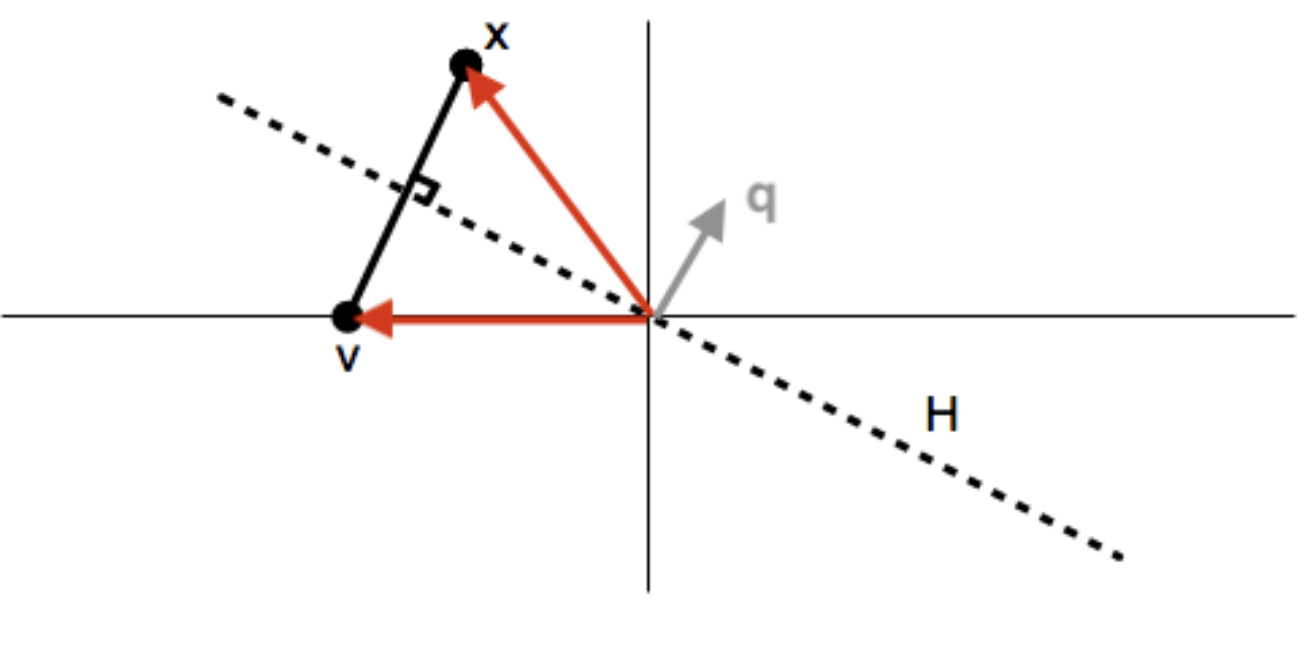

or mathematically
$$
    \mathbf{x} = \begin{bmatrix}
        x_1 \\
        x_2 \\
        \vdots \\
        x_{n}
     \end{bmatrix}, \quad
    H\mathbf{x} = \begin{bmatrix}
        ||\mathbf{x}|| \\
        0 \\
        \vdots \\
        0
    \end{bmatrix} = ||\mathbf{x}|| \mathbf{e}_1.\quad\text{where}\quad\mathbf{e}_1 = \begin{bmatrix}
        1 \\
        0 \\
        \vdots \\
        0
    \end{bmatrix}.
$$
is the first unit vector

This is of course the effect on only one vector.  Any other vector will be reflected across $H$ (technically a hyperplane) which is orthogonal to

$$\mathbf{v} = ||\mathbf{x}|| \hat{e}_1 - \mathbf{x}.$$

This has a similar construction as to the projector complements we were working with before.  Consider the projector defined as

$$
    P x = \left (I - \mathbf{q} \mathbf{q}^T\right)\mathbf{x} = \mathbf{x} - \mathbf{q}(\mathbf{q}^T\mathbf{x})
$$

where $$\mathbf{q} = \frac{\mathbf{v}}{||\mathbf{v}||}.$$

This vector $P\mathbf{x}$ is now orthogonal to $\mathbf{v}$. i.e. lies in the plane $H$

Since we actually want to transform $\mathbf{x}$ to lie in the direction of $\hat{e}_1$ we need to go twice as far as which allows us to identify the matrix $H$ as

$$
    H = I - 2 \mathbf{q} \mathbf{q}^T.
$$

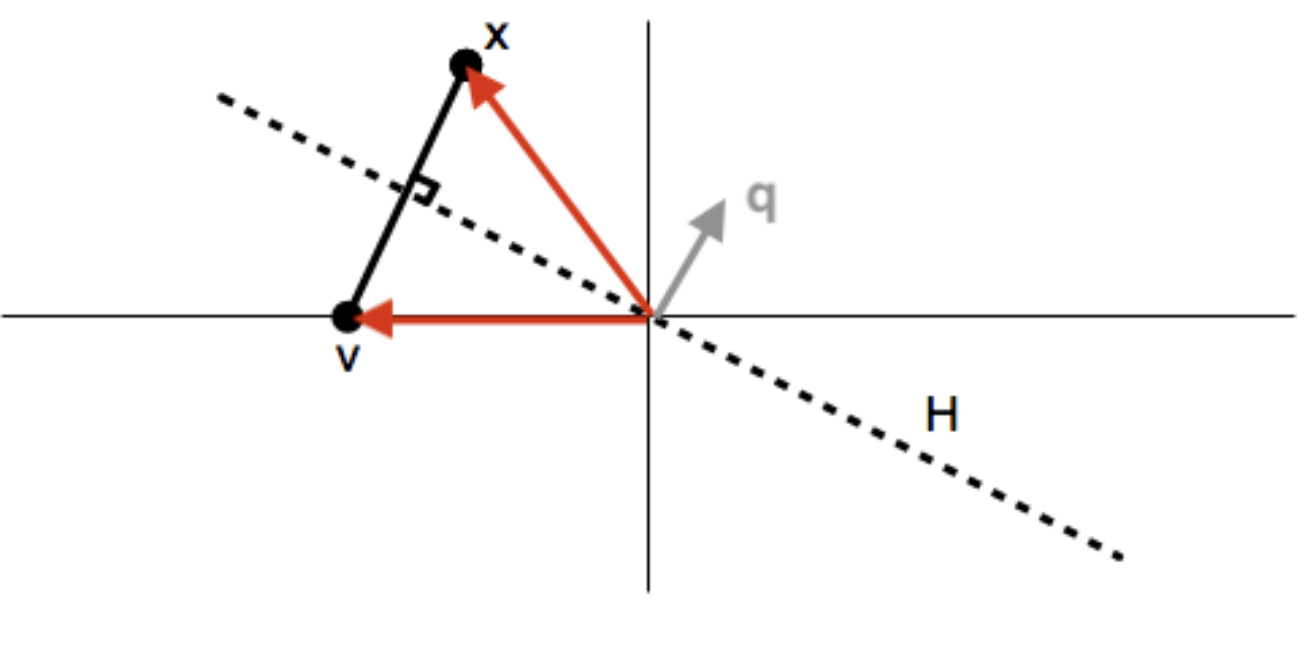

There is actually a non-uniqueness to which direction we reflect over since another definition of $\hat{H}$ which is orthogonal to the one we originally choose is available.  For numerical stability purposes we will choose the reflector that is the most different from $\mathbf{x}$.  This comes back to having difficulties numerically when the vector $\mathbf{x}$ is nearly aligned with $\hat{e}_1$ and therefore one of the $H$ specification.  By convention the $\mathbf{v}$ chosen is defined by

$$
    \mathbf{v} = \text{sign}(x_1)||\mathbf{x}|| \hat{e}_1 + \mathbf{x}.
$$

In [ ]:
# Implementation of Householder QR Factorization
def householder_QR(A, verbose=False):
    R = A.copy()
    m, n = A.shape
    QT = numpy.eye(m)
    for k in range(n):
        x = numpy.zeros(m)
        e = numpy.zeros(m)
        x[k:] = R[k:, k]
        e[k] = 1.0
        # simplest version v = ||x||e - x
        #v =  numpy.linalg.norm(x, ord=2) * e - x
        # alternate version
        v = numpy.sign(x[k]) * numpy.linalg.norm(x, ord=2) * e + x
        v = v / numpy.linalg.norm(v, ord=2)
        R  -= 2.0 * numpy.outer(v,numpy.dot(v.T,R))
        QT  -= 2.0 * numpy.outer(v,numpy.dot(v.T,QT))
    Q = QT.T[:,:n]
    return Q, R

In [ ]:
A = numpy.array([[12, -51, 4], [6, 167, -68], [-4, 24, -41]], dtype=float)
print("Matrix A = ")
print(A)

In [ ]:
%precision 6
Q, R = householder_QR(A, verbose=False)
print("Householder (reduced) Q =\n{}\n".format(Q))
print("Householder (full) R = ")
print(R)

In [ ]:
m, n = A.shape
print("Check to see if factorization worked...||A -QR|| = {}".format(numpy.linalg.norm(A - numpy.dot(Q, R[:n, :n]))))
print(A - numpy.dot(Q, R[:n, :n]))
print("\nCheck if Q is unitary...||Q^TQ -I|| = {}".format(numpy.linalg.norm(Q.T.dot(Q)-numpy.eye(n))))
print(Q.T.dot(Q))

### Comparison of accuracy of the different algorithms

As it turns out, not all $QR$ algorithms produce the same quality of orthogonalization.  Here we provide a few examples that compare the behavior of the 3 different algorithms and `numpy.linalg.qr`

#### Example 1:   Random Matrix QR

Here we construct a large matrix $A$ with a random eigenspace and widely varying eigenvalues.  The values along the diagonal of $R$ gives us some idea of the size of the projections as we go, i.e. the larger the values the less effective we are in constructing orthogonal directions.

In [ ]:
N = 80
# construct a random matrix with known singular values
U, X = numpy.linalg.qr(numpy.random.random((N, N)))
V, X = numpy.linalg.qr(numpy.random.random((N, N)))
S = numpy.diag(2.0**numpy.arange(-1.0, -(N + 1), -1.0))
A = numpy.dot(U, numpy.dot(S, V))

fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)
Q, R = classic_GS(A)
axes.semilogy(numpy.diag(R), 'bo', label="Classic")
Q, R = mod_GS(A)
axes.semilogy(numpy.diag(R), 'ro', label="Modified")
Q, R = householder_QR(A)
axes.semilogy(numpy.diag(R), 'ko', label="Householder")
Q, R = numpy.linalg.qr(A)
axes.semilogy(numpy.diag(R), 'go', label="numpy")

axes.set_xlabel("Index", fontsize=16)
axes.set_ylabel("$R_{ii}$", fontsize=16)
axes.legend(loc=3, fontsize=14)
axes.plot(numpy.arange(0, N), numpy.ones(N) * numpy.sqrt(numpy.finfo(float).eps), 'k--')
axes.plot(numpy.arange(0, N), numpy.ones(N) * numpy.finfo(float).eps, 'k--')

plt.show()

#### Example 2:  Comparing Orthogonality

Consider the $QR$ factorization of the ill-conditioned matrix
$$
    A = \begin{bmatrix}
        0.70000 & 0.70711 \\ 0.70001 & 0.70711
    \end{bmatrix}.
$$

In [ ]:
%precision 16

A = numpy.array([[0.7, 0.70711], [0.70001, 0.70711]])
print('\ncond(A) = {}'.format(numpy.linalg.cond(A)))


To check that the matrix $Q$ is really unitary, we compute $A=QR$ with the different algorithms and compare

$$
    ||Q^TQ - I||
$$

In [ ]:


Q_c, R = classic_GS(A)
r_c = numpy.linalg.norm(numpy.dot(Q_c.transpose(), Q_c) - numpy.eye(2))
print("Classic: ", r_c )

Q, R = mod_GS(A)
print("Modified: ", numpy.linalg.norm(numpy.dot(Q.transpose(), Q) - numpy.eye(2)))

Q_h, R = householder_QR(A)
r_h = numpy.linalg.norm(numpy.dot(Q_h.transpose(), Q_h) - numpy.eye(2))
print("Householder:", r_h)

Q, R = numpy.linalg.qr(A)
r = numpy.linalg.norm(numpy.dot(Q.transpose(), Q) - numpy.eye(2))
print("Numpy: ", r)

print('\ncond(A) = {}'.format(numpy.linalg.cond(A)))
print('r_classic/r_householder = {}'.format(r_c/r_h))

## Applications of the QR

The $QR$ factorization and unitary transformation such as Householder reflections,  play important roles in a wide range of algorithms for Numerical Algorithms

### Least-Squares problems: Solving $A\mathbf{x} = \mathbf{b}$ with QR

We have already discussed solving overdetermined least-squares problems using the $QR$ factorization.  In general,  if we seek least-squares solutions to  $A\mathbf{x}=\mathbf{b}$ and $A=QR$, the problem reduces to solving the triangular problem
$$
R\mathbf{x} = Q^T\mathbf{b}
$$

If we use Householder triangularization to transform $A\rightarrow R$ directly,  we do not need to explicitly form the matrix $Q$ and can  save memory and computation.  If we  consider the augmented system $\begin{bmatrix} A & \mathbf{b}\end{bmatrix}
$ and Apply the same sequence of unitary, rank 1 tranformations we used in the Householder algorithm, the sequence becomes

$$
Q_n\ldots Q_2Q_1\begin{bmatrix} A & \mathbf{b}\end{bmatrix} = \begin{bmatrix} Q^TA & Q^T\mathbf{b}\end{bmatrix} =\begin{bmatrix} R & \mathbf{c}\end{bmatrix}
$$

Thus we just need to solve
$$
    R\mathbf{x} = \mathbf{c}
$$


Alternatively,  during the $QR$ factorization by Householder, we can just store the vectors $\mathbf{q}_1\ldots\mathbf{q}_n$ and reconstruct $Q^T\mathbf{b}$ by rank-1 updates as neccessary.

### Finding Eigenvalues

As it turns out,  the $QR$ factorization and Householder transformation are also extremely useful for finding eigenvalues of a matrix $A$.  There is an entire notebook `13_LA_eigen.ipynb` that develops these ideas in detail. Here we will just discuss the parts that relate to the $QR$ and orthogonalization algorithms.

### The basics

The eigenproblem
$$
    A \mathbf{x} = \lambda \mathbf{x}
$$
can be rewritten as

$$
    ( A - \lambda I)\mathbf{x} = \mathbf{0}
$$

which implies that the eigenvectors are in the Null space of $A-\lambda I$.

However for this matrix to have a non-trivial Null space, requires that $A-\lambda I$ is singular.

### Characteristic Polynomial

If $A-\lambda I$ is singular, it follows that

$$
    \det( A - \lambda I) = {\cal P}_A(\lambda) = 0
$$

where ${\cal P}_A(\lambda)$ can be shown to be a $m$th order polynomial in $\lambda$ known as  the **characteristic polynomial** of a matrix $A$



## Computing Eigenvalues

In basic linear algebra classes we usually find the eigenvalues by directly calculating the roots of ${\cal P}_A(\lambda)$ which can work for low-degree polynomials.    Unfortunately the following theorem (due to Galois) suggests this is not a good way to compute eigenvalues:

**Theorem:** For an $m \geq 5$ there is a polynomial $\mathcal{P}(z)$ of degree $m$ with rational coefficients that has a real root $\mathcal{P}(z_0) = 0$ with the property that $z_0$ cannot be written using any expression involving rational numbers, addition, subtraction, multiplication, division, and $k$th roots.

I.e., there is no way to find the roots of a polynomial of degree $>4$ in a deterministic, fixed number of steps.

#### Not all is lost however!

We just must use an iterative approach where we construct a sequence that converges to the eigenvalues.  

**Some Questions**
* How does this relate to how we found roots previously?
* Why will it still be difficult to use our rootfinding routines to find Eigenvalues?

We will return to how we actually find Eigenvalues (and roots of polynomials) after a bit more review

### Similarity Transformations

Generally, we say any two matrices $A$ and $B$ are **similar** if they can be related through an invertible matrix $M$ as

$$
    A = M^{-1} B M
$$

**Example**

The general Eigen problem
$$
A\mathbf{x}=\lambda\mathbf{x}
$$

is really $n$ problems for each eigenvalue, eigenvector pair i.e.

$$
    A\mathbf{x}_i = \lambda_i\mathbf{x}_i\quad\text{for}\quad i=1,\ldots,n
$$

which can be written concisely in matrix form as

$$
AX =X\Lambda
$$

where $X$ is a matrix whose columns contain the eigenvectors and $\Lambda$ is a diagonal matrix of corresponding eigenvalues.  This form is always true

#### Example Diagonalizable matrices

If a matrix $A\in\mathbb{R}^{n\times n}$ has $n$ linearly independent eigenvectors, then  we say $A$ is *diagonalizable* and we can factor it as

$$
    A = X\Lambda X^{-1}
$$
Where $X$ is a matrix of eigenvectors, and $\Lambda$ is a diagonal matrix of corresponding Eigenvalues.

which says $A$ is similar to $\Lambda$ with similarity transform $X$

#### Theorem:
If $A$ and $B$ are similar matrices, they have the same eigenvalues and their eigenvectors are related through an invertible matrix $M$

**Proof**: Let

$$
    B = M A M^{-1}
$$
or
$$
    BM = MA
$$

if $A\mathbf{x} = \lambda\mathbf{x}$  then
$$
    BM\mathbf{x} = M A\mathbf{x} = \lambda M\mathbf{x}
$$
or
$$
    B\mathbf{y} = \lambda\mathbf{y}
$$

which shows that $\lambda$ is also an eigenvalue of $B$ with corresponding eigenvector $\mathbf{y} = M\mathbf{x}$

### Schur Factorization

A **Schur factorization** of a matrix $A$ is defined as

$$
    A = Q T Q^\ast
$$

where $Q$ is unitary and $T$ is upper-triangular.  Because $Q^\ast=Q^{-1}$ (for square unitary matrices). It follows directly that $A$ and $T$ are similar.  

*  Good News!  $T$ is upper triangular so its eigenvalues can just be read of the diagonal
*  Bad News! There is no deterministic way to calculate $T$ as that would violate Galois theory of polynomials

**Theorem:** Every matrix $A \in \mathbb C^{m \times m}$ has a Schur factorization.

**Partial Proof** for a diagonalizable matrix.  If $A$ is diagonalizable, $A=X\Lambda X^{-1}$.  But we know we can always factor $X=QR$ and substitute to show

$$
    A = Q(R\Lambda R^{-1})Q^T
$$

and it is not hard to show that the product $R\Lambda R^{-1}$ is also an upper triangular matrix (exercise left to the reader).  

(For a non-diagonalizable matrix the proof requires showing the existence of the Jordan form $A=MJM^{-1}$)

Note that the above results imply the following
 - An eigen-decomposition $A = X \Lambda X^{-1}$ exists if and only if $A$ is non-defective (it has a complete set of eigenvectors)
 - A unitary transformation $A = Q \Lambda Q^\ast$ exists if and only if $A$ is Hermitian ($A^\ast = A$)
 - A Schur factorization always exists

Note that each of these lead to a means for isolating the eigenvalues of a matrix and will be useful when considering algorithms for finding them.

### Hessenberg form

The first step to finding the Schur factorization is to try and get $A$ as close to triangular as possible without changing its eigenvalues. This requires a series of similarity transformations.

As it turns out,  the closest we can do is to reduce it to Hessenberg form which is upper triangular with one extra subdiagonal.  Which can be done with $n$ explicit similarity transformations using Householder Transformations

$$
    \begin{bmatrix}
        \text{x} & \text{x} & \text{x} & \text{x} & \text{x} \\
        \text{x} & \text{x} & \text{x} & \text{x} & \text{x} \\
        \text{x} & \text{x} & \text{x} & \text{x} & \text{x} \\
        \text{x} & \text{x} & \text{x} & \text{x} & \text{x} \\
        \text{x} & \text{x} & \text{x} & \text{x} & \text{x}
    \end{bmatrix} \overset{H_1^\ast A_0 H_1}{\rightarrow}
    \begin{bmatrix}
        \text{x} & \text{x} & \text{x}& \text{x} & \text{x} \\
        \text{x} & \text{x} & \text{x}& \text{x} & \text{x} \\
        0 & \text{x} & \text{x}& \text{x} & \text{x} \\
        0 & \text{x} & \text{x}& \text{x} & \text{x} \\
        0 & \text{x} & \text{x}& \text{x} & \text{x}
    \end{bmatrix} \overset{H_2^\ast A_1H_2}{\rightarrow}
    \begin{bmatrix}
        \text{x} & \text{x} & \text{x}& \text{x} & \text{x} \\
        \text{x} & \text{x} & \text{x}& \text{x} & \text{x} \\
        0 & \text{x} & \text{x}& \text{x} & \text{x} \\
        0 & 0 & \text{x}& \text{x} & \text{x} \\
        0 & 0 & \text{x}& \text{x} & \text{x}
    \end{bmatrix} \overset{H_3^\ast A_2H_3}{\rightarrow}
    \begin{bmatrix}
        \text{x} & \text{x} & \text{x}& \text{x} & \text{x} \\
        \text{x} & \text{x} & \text{x}& \text{x} & \text{x} \\
        0 & \text{x} & \text{x}& \text{x} & \text{x} \\
        0 & 0 & \text{x}& \text{x} & \text{x} \\
        0 & 0 & 0 & \text{x} & \text{x}
    \end{bmatrix}
$$

so we have the sequence $H = Q^\ast A Q$ which has the same eigenvalues as the original matrix $A$.  

**Question**?  Why can't we just use Householder to take $A\rightarrow T$ like we did for the $QR$?

## QR/RQ Algorithm

Given a matrix in Hessenberg form, it turns out we can use repeated $QR$ factorizations to reduce the size of the subdiagonal and iterate towards the Schur factorization  to find all the eigenvalues simultaneously.

The simplest algorithm just iterates
```python
    while not converged:
        Q, R = numpy.linalg.qr(A)
        A = R.dot(Q)        
```
calculating the $QR$ factorization of $A$, then forming a new $A=RQ$,  This sequence will eventually converge to the Schur decomposition of the matrix $A$.

Code this up and see what happens.

In [ ]:
%precision 6
m = 3
A0 = numpy.array([[2, 1, 1], [1, 3, 1], [1, 1, 4]])

In [ ]:
MAX_STEPS = 10

A=A0
print('A=')
print(A)
for i in range(MAX_STEPS):
    Q, R = numpy.linalg.qr(A)
    A = numpy.dot(R, Q)
    print()
    print("A({}) =".format(i))
    print(A)

In [ ]:
print()
print("True eigenvalues: ")
print(numpy.sort(numpy.linalg.eigvals(A0)))
print()
print("Computed eigenvalues: ")
print(numpy.sort(numpy.diag(A)))

So why does this work?  The first step is to find the $QR$ factorization  

$$A^{(k-1)} = Q^{(k)}R^{(k)}$$



which is equivalent to finding

$$
    (Q^{(k)})^T A^{(k-1)} = R^{(k)}
$$

and multiplying on the right leads to

$$
    (Q^{(k)})^T A^{(k-1)} Q^{(k)} = R^{(k)} Q^{(k)} = A^{(k)}.
$$

In this way we can see that this is a similarity transformation of the matrix $A^{(k-1)}$ since the $Q^{(k)}$ is an orthogonal matrix ($Q^{-1} = Q^T$). This of course is not a great idea to do directly but works great in this case as we iterate to find the upper triangular matrix $R^{(k)}$ which is exactly where the eigenvalues appear.

In practice this basic algorithm is modified to include a few additions:

1. Before starting the iteration $A$ is reduced to tridiagonal or Hessenberg form.
1. Motivated by the inverse power iteration we observed we instead consider a shifted matrix $A^{(k)} - \mu^{(k)} I$ for factoring.  The $\mu$ picked is related to the estimate given by the Rayleigh quotient.  Here we have

$$
    \mu^{(k)} = \frac{(q_m^{(k)})^T A q_m^{(k)}}{(q_m^{(k)})^T q_m^{(k)}} = (q_m^{(k)})^T A q_m^{(k)}.
$$

1. Deflation is used to reduce the matrix $A^{(k)}$ into smaller matrices once (or when we are close to) finding an eigenvalue to simplify the problem.

This has been the standard approach until recently for finding eigenvalues of a matrix.

### Application:  Finding the roots of a polynomial

Numpy has a nice function called roots which returns the $n$ roots of a $n$th degree polynomial

$$
   p(x) = p_0 x^n + p_1 x^{n-1} + p_2 x^{n-2} + \ldots + p_n
$$

described by a $n+1$ vector of coefficients $\mathbf{p}$

In [ ]:
p = numpy.array([ 1, 1, -1])
r = numpy.roots(p)
print(r)

In [ ]:
p = numpy.random.rand(8)
r = numpy.roots(p)
print(r)

This routine, does not try and actually find the roots of a high-order polynomial,  instead it actually calculates the eigenvalues of a **companion matrix** $C$ whose characteristic polynomial $P_C(\lambda)$ is the **monic** polynomial

$$c(x) = c_0 + c_1 x + c_2 x^2 + \ldots + c_{n-1} x^{n-1} + x^n $$

It can be shown that this matrix can be constructed as ([see e.g.](https://en.wikipedia.org/wiki/Companion_matrix))
$$
C(p)=\begin{bmatrix}
0 & 0 & \dots & 0 & -c_0 \\
1 & 0 & \dots & 0 & -c_1 \\
0 & 1 & \dots & 0 & -c_2 \\
\vdots & \vdots & \ddots & \vdots & \vdots \\
0 & 0 & \dots & 1 & -c_{n-1}
\end{bmatrix}.
$$


In [ ]:
def myroots(p, verbose=False):
    ''' Calculate the roots of a polynomial described by coefficient vector
    in numpy.roots order
    p(x) = p_0 x^n + p_1 x^{n-1} + p_2 x^{n-2} + \ldots + p_n
    by finding the eigenvalues of the companion matrix

    returns:
    --------
    eigenvalues sorted by |\lambda|

    '''

    # construct the companion matrix of the coefficient vector c
    # make p monic and reverse the order for this definition of the companion matrix
    c = numpy.flip(p/p[0])
    if verbose:
        print(c)
    m = len(c) - 1
    C = numpy.zeros((m,m))
    C[:,-1] = -c[:-1]
    C[1:,:-1] = numpy.eye(m-1)
    if verbose:
        print('C = \n{}'.format(C))

    # calculate the eigenvalues of the companion matrix, then sort by |lambda|
    eigs = numpy.linalg.eigvals(C)
    index = numpy.flip(numpy.argsort(numpy.abs(eigs)))
    return eigs[index]



In [ ]:
p = numpy.array([ 1, 1, -1])
r = numpy.roots(p)
print(r)
mr = myroots(p)
print
print(mr)

In [ ]:
%precision 4
p = numpy.random.rand(5)
r = numpy.roots(p)
print('nproots: {}'.format(r))
mr = myroots(p)
print()
print('myroots: {}'.format(mr))